In [1]:
import pandas as pd 
import numpy as np

# https://github.com/petrosDemetrakopoulos/RNN-Beatles-lyrics-generator
# https://github.com/starry91/Lyric-Generator#2-lyric-generator-based-on-word-level-rnn

In [2]:
import torch 
torch.cuda.is_available()

False

In [2]:
# ssh -i "ling380.pem" ec2-user@ec2-3-21-233-161.us-east-2.compute.amazonaws.com

In [3]:
# Reading in language CSV 
data = pd.read_csv("language-processed-data.csv")

In [4]:
print(data.shape)
print(data.head())

(290501, 6)
   Unnamed: 0           artist genre            title  \
0           0  beyonce-knowles   Pop        ego remix   
1           1  beyonce-knowles   Pop     then tell me   
2           2  beyonce-knowles   Pop          honesty   
3           3  beyonce-knowles   Pop  you are my rock   
4           4  beyonce-knowles   Pop    black culture   

                                              lyrics language  
0  Oh baby, how you doing?\nYou know I'm gonna cu...       en  
1  playin' everything so easy,\nit's like you see...       en  
2  If you search\nFor tenderness\nIt isn't hard t...       en  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...       en  
4  Party the people, the people the party it's po...       en  


## Prediction

- User inputs a song title, and how many words they want the song to be. 
- Network does, for example, 100 predictions, and in the training phrase we know what word we need to generate. 
- (genre, song title); have a marker that it's the end of the title 

# Word Level LSTM

In [5]:
stopChars = [',','(',')','.','-','[',']','"']
# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
#     text = text.replace('\n', ' ').replace('\t','')
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

# tokenization 
def corpusToList(corpus):
    corpusList = [w for w in corpus.split(' ')] 
    corpusList = [i for i in corpusList if i] #removing empty strings from list
    return corpusList

In [6]:
data1 = data
data1 = data1[data1['genre'] == 'Country'].sample(1000)
data1['lyrics']= data1['lyrics'].apply(preprocessText)
print(data1.head())
print(data1.shape)

        Unnamed: 0          artist    genre                    title  \
43566        67748     eddy-arnold  Country    then i ll be over you   
18432        29535   bill-anderson  Country         before i met you   
41121        63690  avett-brothers  Country       i and love and you   
210452      318639    connie-smith  Country          god is abundant   
49794        76742  dierks-bentley  Country  i can only think of one   

                                                   lyrics language  
43566   when i try to go to sleep and know\nthat i won...       en  
18432   well i thought i had seen good lookin' men in ...       en  
41121   load the car and write the note\ngrab your bag...       en  
210452  god is abundant in mercy and love he died to r...       en  
49794   pullin' into the fast lane\non the leavin' sid...       en  
(1000, 6)


In [7]:
import re
newlines = re.sub("\n", " \n ", data1['lyrics'].str.cat(sep='\n').lower())
exclamation = re.sub("!", " ! ", newlines)
question = re.sub("!", " ! ", exclamation)
DP_text = re.findall(r'\S+|\n', question)
print('corpus length:', len(DP_text))

corpus length: 211784


In [8]:
# Counting characters appeared in all lyrics
words = sorted(list(set(DP_text)))
print('total words:', len(words))

total words: 8835


In [9]:
# Create a dictionary of characters, see the index of characters.
char_to_int = dict((c, i) for i, c in enumerate(words))
int_to_char = dict((i, c) for i, c in enumerate(words))

In [10]:
seq_length = 10 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    # range from current index to sequence length charaters
    sentences.append(DP_text[i: i + seq_length])  
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target characters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
[['when' 'i' 'try' 'to' 'go' 'to' 'sleep' 'and' 'know' '\n']
 ['i' 'try' 'to' 'go' 'to' 'sleep' 'and' 'know' '\n' 'that']
 ['try' 'to' 'go' 'to' 'sleep' 'and' 'know' '\n' 'that' 'i']
 ['to' 'go' 'to' 'sleep' 'and' 'know' '\n' 'that' 'i' "won't"]
 ['go' 'to' 'sleep' 'and' 'know' '\n' 'that' 'i' "won't" 'lie']]
Target characters
['that' 'i' "won't" 'lie' 'awake']
Number of sequences: 211774


In [11]:
# transferring the character to index 
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [12]:
train_x,train_y = getdata(sentences, next_chars)
print(train_x)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

[[8477. 3889. 8053. ...  362. 4291.    0.]
 [3889. 8053. 7866. ... 4291.    0. 7709.]
 [8053. 7866. 3261. ...    0. 7709. 3889.]
 ...
 [   0. 5227. 3889. ... 1195. 3889. 1262.]
 [5227. 3889. 1263. ... 3889. 1262.  213.]
 [3889. 1263. 1753. ... 1262.  213. 7716.]]
Shape of training_x: (211774, 10)
Shape of training_y: (211774,)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [14]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long)
Y_train_tensor = torch.tensor(train_y, dtype=torch.long)
print('Shape of training_x:', X_train_tensor.shape)
print('Shape of training_y:', Y_train_tensor.shape)

Shape of training_x: torch.Size([211774, 10])
Shape of training_y: torch.Size([211774])


In [15]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128)

In [16]:
model = Simple_LSTM(len(words),256,256)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # Using Adam optimizer

In [17]:
# checking if we are using cuda 
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import time # Add time counter
avg_losses_f = []
n_epochs=30

for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
        
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    avg_losses_f.append(avg_loss)    
    
print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

Epoch:  0


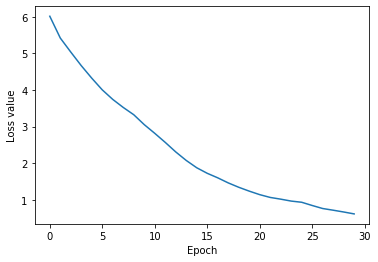

In [185]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_f)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [186]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [188]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
sentence = ["i", "remember", "dad", "walking", "out", "that", "door", "\n", "but", "i"]
variance = .5
generated = []
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x))
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
    
print(" ".join(original + generated))

i remember dad walking out that door 
 but i know the power of a song when you would have to try 
 he's not someone from the scene 
 but from the crowd let me rest and dream awhile say be home 
 and shows my lady down the moon 
 he took her off the block take 
 put a little love in your heart each and every love you say 
 id walk in home 
 chorus 
 now just just love that goodbye old friend farewell it took 
 but when you hold me when you punch that way 
 when i know the power of a song 
 when a song hits you right 
 poured my soul into stories of day 
 when i truck on your tombstone 
 one thing that i would 
 do my happiness for me 
 next good love makes you leave 
 raise some hell or hit your knees 
 all i love you and i know why i said 
 i wanna know 
 if i could have you back again 
 time when i don't want 
 goodbye old friend farewell it seems 
 we'll dance again in my dreams 
 goodbye old friend farewell it seems 
 we'll dance again in my dreams 
 goodbye old friend farewell it s